In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier

df = pd.read_excel("Kickstarter.xlsx")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15215 entries, 0 to 15214
Data columns (total 46 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id                        15215 non-null  int64         
 1   name                      15215 non-null  object        
 2   goal                      15215 non-null  int64         
 3   pledged                   15215 non-null  float64       
 4   state                     15215 non-null  object        
 5   disable_communication     15215 non-null  bool          
 6   country                   15215 non-null  object        
 7   currency                  15215 non-null  object        
 8   deadline                  15215 non-null  datetime64[ns]
 9   state_changed_at          15215 non-null  datetime64[ns]
 10  created_at                15215 non-null  datetime64[ns]
 11  launched_at               15215 non-null  datetime64[ns]
 12  staff_pick        

In [2]:
# Define X and y
X = df.drop(columns=['state'])  # Replace 'state' with your target column
y = df['state'] 

# Identify columns with non-numeric data
non_numeric_cols = X.select_dtypes(include=['object', 'category', 'datetime64']).columns
print(f"Non-Numeric Columns to Drop or Transform: {non_numeric_cols.tolist()}")

# Drop non-numeric and datetime columns
X_cleaned = X.drop(columns=non_numeric_cols, errors='ignore')
print(f"Remaining Columns after Dropping Non-Numeric Data: {X_cleaned.columns.tolist()}")

Non-Numeric Columns to Drop or Transform: ['name', 'country', 'currency', 'deadline', 'state_changed_at', 'created_at', 'launched_at', 'category', 'deadline_weekday', 'state_changed_at_weekday', 'created_at_weekday', 'launched_at_weekday', 'main_category']
Remaining Columns after Dropping Non-Numeric Data: ['id', 'goal', 'pledged', 'disable_communication', 'staff_pick', 'backers_count', 'static_usd_rate', 'usd_pledged', 'spotlight', 'name_len', 'name_len_clean', 'blurb_len', 'blurb_len_clean', 'deadline_month', 'deadline_day', 'deadline_yr', 'deadline_hr', 'state_changed_at_month', 'state_changed_at_day', 'state_changed_at_yr', 'state_changed_at_hr', 'created_at_month', 'created_at_day', 'created_at_yr', 'created_at_hr', 'launched_at_month', 'launched_at_day', 'launched_at_yr', 'launched_at_hr', 'staff_pick.1', 'show_feature_image', 'video']


In [3]:
# Transform datetime columns into useful numeric features
for col in non_numeric_cols:
    if col in X.select_dtypes(include=['datetime64']).columns:
        X[f'{col}_year'] = X[col].dt.year
        X[f'{col}_month'] = X[col].dt.month
        X[f'{col}_day'] = X[col].dt.day
        X[f'{col}_weekday'] = X[col].dt.weekday

# Drop original datetime columns
X_cleaned = X.drop(columns=non_numeric_cols, errors='ignore')

print("Final Data Types of Features:")
print(X_cleaned.dtypes)

# Check for any remaining non-numeric data
if X_cleaned.select_dtypes(include=['object', 'category', 'datetime64']).shape[1] > 0:
    print("Warning: Non-numeric columns remain!")
else:
    print("All columns are now numeric.")

Final Data Types of Features:
id                          int64
goal                        int64
pledged                   float64
disable_communication        bool
staff_pick                   bool
backers_count               int64
static_usd_rate           float64
usd_pledged               float64
spotlight                    bool
name_len                    int64
name_len_clean              int64
blurb_len                   int64
blurb_len_clean             int64
deadline_month              int32
deadline_day                int32
deadline_yr                 int64
deadline_hr                 int64
state_changed_at_month      int32
state_changed_at_day        int32
state_changed_at_yr         int64
state_changed_at_hr         int64
created_at_month            int32
created_at_day              int32
created_at_yr               int64
created_at_hr               int64
launched_at_month           int32
launched_at_day             int32
launched_at_yr              int64
launched_at_hr    

In [4]:
# Check the shape of X_cleaned and y
print("Shape of X_cleaned (Features):", X_cleaned.shape)
print("Remaining Columns in X_cleaned:", X_cleaned.columns.tolist())
print("Shape of y (Target):", y.shape)
print("Unique values in y:", y.unique())

# Ensure X_cleaned and y are non-empty and aligned
if X_cleaned.shape[0] == 0:
    raise ValueError("No rows left in the dataset after preprocessing!")
if X_cleaned.shape[1] == 0:
    raise ValueError("No usable features left after preprocessing!")
if len(y.unique()) < 2:
    raise ValueError("Target variable has insufficient classes for classification!")

Shape of X_cleaned (Features): (15215, 36)
Remaining Columns in X_cleaned: ['id', 'goal', 'pledged', 'disable_communication', 'staff_pick', 'backers_count', 'static_usd_rate', 'usd_pledged', 'spotlight', 'name_len', 'name_len_clean', 'blurb_len', 'blurb_len_clean', 'deadline_month', 'deadline_day', 'deadline_yr', 'deadline_hr', 'state_changed_at_month', 'state_changed_at_day', 'state_changed_at_yr', 'state_changed_at_hr', 'created_at_month', 'created_at_day', 'created_at_yr', 'created_at_hr', 'launched_at_month', 'launched_at_day', 'launched_at_yr', 'launched_at_hr', 'staff_pick.1', 'show_feature_image', 'video', 'deadline_year', 'state_changed_at_year', 'created_at_year', 'launched_at_year']
Shape of y (Target): (15215,)
Unique values in y: ['successful' 'failed' 'live' 'canceled']


Unique values in 'state' column before filtering:
['successful' 'failed' 'live' 'canceled']
Unique values in 'state' after filtering:
['successful' 'failed']
Dataset shape after filtering: (14463, 46)
Shape of X (features): (14463, 45)
Shape of y (target): (14463,)
Dropping Non-Numeric Columns: ['name', 'country', 'currency', 'deadline', 'state_changed_at', 'created_at', 'launched_at', 'category', 'deadline_weekday', 'state_changed_at_weekday', 'created_at_weekday', 'launched_at_weekday', 'main_category']


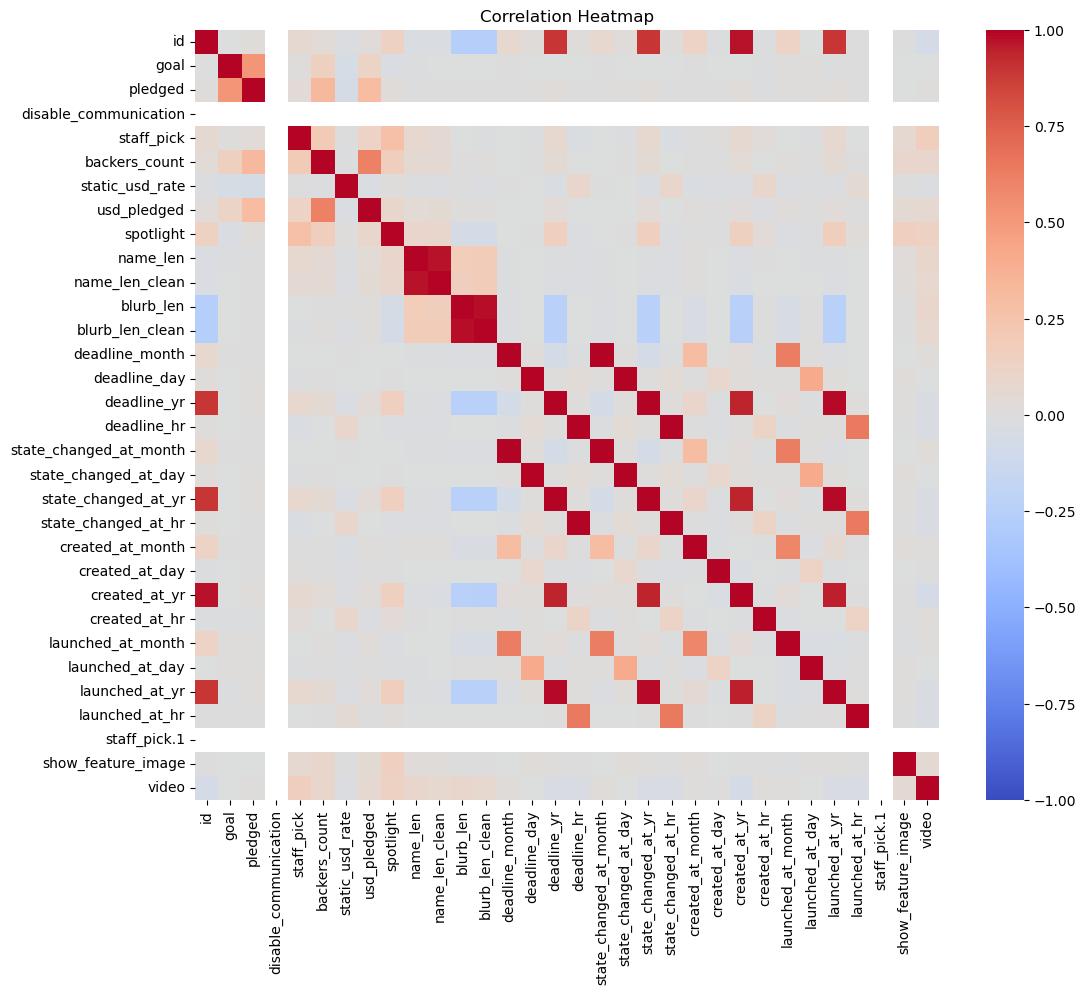

Highly correlated features (corr > 0.9): {'launched_at_yr', 'state_changed_at_hr', 'blurb_len_clean', 'created_at_yr', 'state_changed_at_month', 'name_len_clean', 'state_changed_at_day', 'state_changed_at_yr'}
Remaining Columns After Dropping Highly Correlated Features: ['id', 'goal', 'pledged', 'disable_communication', 'staff_pick', 'backers_count', 'static_usd_rate', 'usd_pledged', 'spotlight', 'name_len', 'blurb_len', 'deadline_month', 'deadline_day', 'deadline_yr', 'deadline_hr', 'created_at_month', 'created_at_day', 'created_at_hr', 'launched_at_month', 'launched_at_day', 'launched_at_hr', 'staff_pick.1', 'show_feature_image', 'video']
Remaining Columns in X_cleaned: ['id', 'goal', 'pledged', 'disable_communication', 'staff_pick', 'backers_count', 'static_usd_rate', 'usd_pledged', 'spotlight', 'name_len', 'blurb_len', 'deadline_month', 'deadline_day', 'deadline_yr', 'deadline_hr', 'created_at_month', 'created_at_day', 'created_at_hr', 'launched_at_month', 'launched_at_day', 'launc

In [5]:
# Step 1: Inspect Target Column
print("Unique values in 'state' column before filtering:")
print(df['state'].unique())

# Filter rows for 'successful' and 'failed' states
df = df[df['state'].isin(['successful', 'failed'])]

# Verify filtering
print("Unique values in 'state' after filtering:")
print(df['state'].unique())
print(f"Dataset shape after filtering: {df.shape}")

# Step 2: Create Target and Features
X = df.drop(columns=['state'])
y = df['state'].map({'successful': 1, 'failed': 0})  # Map target to binary

# Check shapes
print("Shape of X (features):", X.shape)
print("Shape of y (target):", y.shape)

# Step 3: Drop Non-Numeric Columns
non_numeric_cols = X.select_dtypes(include=['object', 'category', 'datetime64']).columns
print(f"Dropping Non-Numeric Columns: {non_numeric_cols.tolist()}")
X_cleaned = X.drop(columns=non_numeric_cols, errors='ignore')

# Step 4: Handling high correlated columns
# Calculate the correlation matrix
corr_matrix = X_cleaned.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

# Identify highly correlated features
high_corr_features = set()
threshold = 0.9

for i in range(corr_matrix.shape[0]):
    for j in range(i + 1, corr_matrix.shape[1]):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[j]
            high_corr_features.add(colname)

print(f"Highly correlated features (corr > {threshold}): {high_corr_features}")

# Drop highly correlated features
X_cleaned = X_cleaned.drop(columns=high_corr_features, errors='ignore')
print("Remaining Columns After Dropping Highly Correlated Features:", X_cleaned.columns.tolist())

# Verify remaining features
print("Remaining Columns in X_cleaned:", X_cleaned.columns.tolist())
print("Shape of X_cleaned:", X_cleaned.shape)

In [6]:
# Step 5: Check Data Alignment
if X_cleaned.shape[0] == 0 or X_cleaned.shape[1] == 0:
    raise ValueError("No usable rows or columns left in the dataset!")

# Step 6: Check Target Validity
if len(y.unique()) < 2:
    raise ValueError("Target variable has insufficient classes for classification!")

In [7]:
# Step 7: Drop features that might cause data leakage
leakage_features = ['pledged', 'usd_pledged', 'backers_count', 'spotlight',
                   'currency','state_changed_at_weekday','state_changed_at_month', 'state_changed_at_day',
                   'state_changed_at_yr','state_changed_at_hr','state_changed_at','id','disable_communication']

X_cleaned = X_cleaned.drop(columns=[col for col in leakage_features if col in X_cleaned.columns], errors='ignore')
print("Remaining Columns After Removing Leakage Features:", X_cleaned.columns.tolist())

Remaining Columns After Removing Leakage Features: ['goal', 'staff_pick', 'static_usd_rate', 'name_len', 'blurb_len', 'deadline_month', 'deadline_day', 'deadline_yr', 'deadline_hr', 'created_at_month', 'created_at_day', 'created_at_hr', 'launched_at_month', 'launched_at_day', 'launched_at_hr', 'staff_pick.1', 'show_feature_image', 'video']
